# RESULTADOS

In [203]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm

from sklearn.neighbors import NearestNeighbors

# GENERACIÓN DE POSICIONES

In [197]:
# A few utility functions to p

def limit_to_box(x, box):
    """select only the points within a given box."""
    mf = x.copy()
    for i, t in enumerate(box):
        mf = mf[mf[:, i] >= t[0], :]
        mf = mf[mf[:, i] <= t[1], :]
    return mf

def print_range(goc):
    """prints the 3d range occupied by the cell population"""
    print(
        "Current range:\n",
        "x: [{}, {}]\n".format(goc[:, 0].min(), goc[:, 0].max()),
        "y: [{}, {}]\n".format(goc[:, 1].min(), goc[:, 1].max()),
        "z: [{}, {}]".format(goc[:, 2].min(), goc[:, 2].max()),
    )

def fix_coords(x, bbox):
    """removes the cells in a 25 um-wide gutter."""
    y = x - 25
    y = limit_to_box(y, bbox)
    print_range(y)
    return y


In [200]:
# load the data
fname = "cell_positions.npz"
#fname = "../../test_data/generated_positions/coords_20190626_1_6.npz"
f = np.load(fname)


# readjuct the data to the bounding box - note that the data were generated in a larger volume
bbox = [[0, 300], [0, 300], [0, 86]]
grc = fix_coords(f['grc'], bbox) # here we use the unperturbed position
glo = fix_coords(f['glo'], bbox)
goc = fix_coords(f['goc'], bbox)


grx = grc + np.random.randn(*grc.shape)*0.2 # add perturbation, corresponding to the softness margin, 0.2 um here.
glx = glo + np.random.randn(*glo.shape)
gox = goc + np.random.randn(*goc.shape)

Current range:
 x: [0.054345774004193714, 299.9957806322272]
 y: [0.03166163265753852, 299.9325431937576]
 z: [0.013313864767521721, 85.99859539025597]
Current range:
 x: [0.11267012719318359, 299.9231344847608]
 y: [0.028478011686804194, 299.96113548821415]
 z: [0.000662658932242266, 85.97432803440546]
Current range:
 x: [4.460000000000001, 299.34]
 y: [9.61, 289.59]
 z: [0.9899999999999984, 84.53]


In [204]:
nn = NearestNeighbors()
nn.fit(grx)
dists, nnids = nn.kneighbors(grx, n_neighbors=2, return_distance=True)

nn.fit(grc)
dists_u, nnids = nn.kneighbors(grc, n_neighbors=2, return_distance=True)

nnids = nnids[:,1]
dists = dists[:,1]

dists_u = dists_u[:,1]

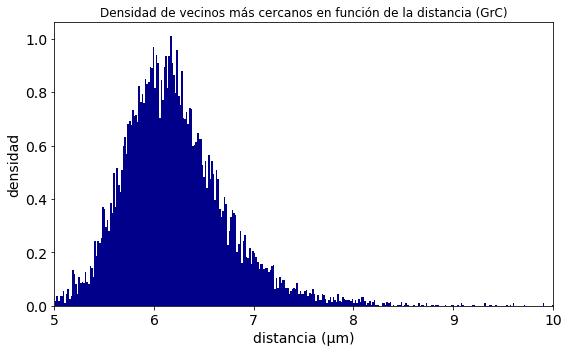

In [205]:
_, ax = plt.subplots(figsize=(8, 5))
ax.hist(dists, 450, density=True, color = 'darkblue')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

ax.set(
    xlim=[5, 10],
    xlabel='distancia (μm)',
    ylabel='densidad'
)

plt.title('Densidad de vecinos más cercanos en función de la distancia (GrC)')
plt.tight_layout()
#plt.savefig('nn_dist_hist_grc.png', dpi=600)

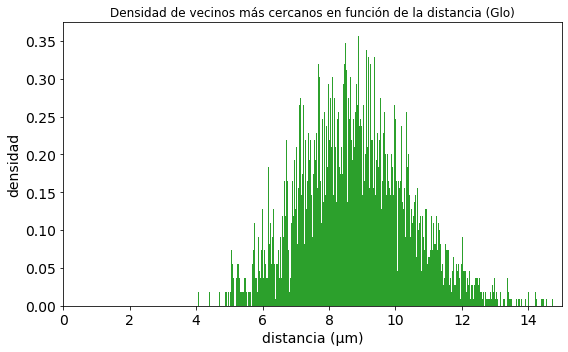

In [206]:
## para las glomérulos
nn = NearestNeighbors()
nn.fit(glo)
dists, nnids = nn.kneighbors(glo, n_neighbors=2, return_distance=True)

nn.fit(glx)
dists_u, nnids = nn.kneighbors(glx, n_neighbors=2, return_distance=True)

nnids = nnids[:,1]
dists = dists[:,1]

dists_u = dists_u[:,1]

_, ax = plt.subplots(figsize=(8,5))
ax.hist(dists, 450, density=True, color = 'tab:green')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

ax.set(
    xlim=[0, 15],
    xlabel='distancia (μm)',
    ylabel='densidad'
)

plt.title('Densidad de vecinos más cercanos en función de la distancia (Glo)')
plt.tight_layout()
#plt.savefig('nn_dist_hist_glo.png', dpi=600)

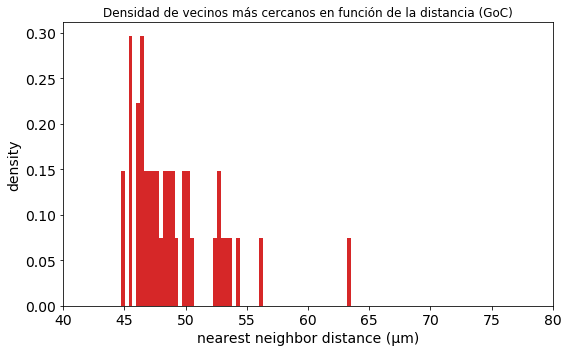

In [207]:
## para las glomérulos
nn = NearestNeighbors()
nn.fit(goc)
dists, nnids = nn.kneighbors(goc, n_neighbors=2, return_distance=True)

nn.fit(gox)
dists_u, nnids = nn.kneighbors(gox, n_neighbors=2, return_distance=True)

nnids = nnids[:,1]
dists = dists[:,1]

dists_u = dists_u[:,1]

_, ax = plt.subplots(figsize=(8,5))
ax.hist(dists, 60, density=True, color='tab:red')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

ax.set(
    xlim=[40, 80],
    xlabel='nearest neighbor distance (μm)',
    ylabel='density'
)


plt.title('Densidad de vecinos más cercanos en función de la distancia (GoC)')

plt.tight_layout()
#plt.savefig('nn_dist_hist_goc.png', dpi=600)

In [208]:
# we limit the calculation to "inside" cells to avoid the boundary effect.
gry = limit_to_box(grx, [[15, 270], [15, 270], [15, 70]])

nn = NearestNeighbors(n_jobs=-1)
nn.fit(grx)

mcounts = []
sdcounts = []
dists = np.linspace(0, 30, 240)
for r in tqdm(dists):
    count = np.frompyfunc(lambda x: x.size, 1, 1)(nn.radius_neighbors(
        gry, radius=r, return_distance=False
    )).astype(float) - 1
    mcounts.append(count.mean())
    sdcounts.append(count.std()/np.sqrt(count.size))

# mcount = count.mean()
# sdcount = count.std()
# print('{} ± {}'.format(mcount, sdcount))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


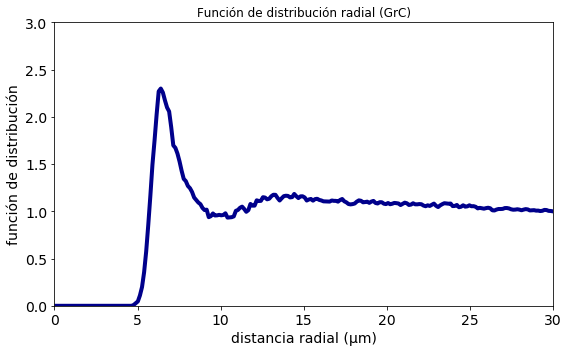

In [209]:
cc2 = np.gradient(mcounts)/(dists**2)
cc2_0 = cc2[-1]
cc2 = cc2/cc2_0

mcounts = np.array(mcounts)
sdcounts = np.array(sdcounts)

cc2_u = np.gradient(mcounts + 150*sdcounts)/(dists**2+0.001)/cc2_0
cc2_d = np.gradient(mcounts - 150*sdcounts)/(dists**2+0.001)/cc2_0

_, ax = plt.subplots(figsize=(8,5))
ax.plot(dists, cc2, 'k', linewidth=4, color = 'darkblue')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

ax.set(
    ylim = [0, 3],
    xlim = [0, 30],
    xlabel='distancia radial (μm)',
    ylabel='función de distribución'
)

plt.title('Función de distribución radial (GrC)')
plt.tight_layout()
#plt.savefig('cc2_grc.png', dpi=600)

In [210]:
# we limit the calculation to "inside" cells to avoid the boundary effect.
gly = limit_to_box(glx, [[15, 270], [15, 270], [15, 70]])

nn = NearestNeighbors(n_jobs=-1)
nn.fit(glx)

mcounts = []
sdcounts = []
dists = np.linspace(0, 30, 240)
for r in tqdm(dists):
    count = np.frompyfunc(lambda x: x.size, 1, 1)(nn.radius_neighbors(
        gly, radius=r, return_distance=False
    )).astype(float) - 1
    mcounts.append(count.mean())
    sdcounts.append(count.std()/np.sqrt(count.size))

# mcount = count.mean()
# sdcount = count.std()
# print('{} ± {}'.format(mcount, sdcount))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


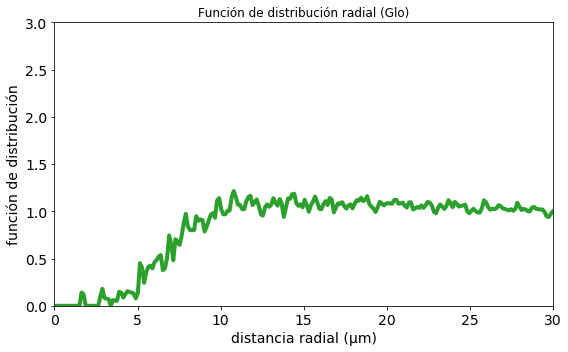

In [211]:
cc2 = np.gradient(mcounts)/(dists**2)
cc2_0 = cc2[-1]
cc2 = cc2/cc2_0

mcounts = np.array(mcounts)
sdcounts = np.array(sdcounts)

cc2_u = np.gradient(mcounts + 150*sdcounts)/(dists**2+0.001)/cc2_0
cc2_d = np.gradient(mcounts - 150*sdcounts)/(dists**2+0.001)/cc2_0

_, ax = plt.subplots(figsize=(8,5))
ax.plot(dists, cc2, 'k', linewidth=4, color = 'tab:green')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
ax.set(
    ylim = [0, 3],
    xlim = [0, 30],
    xlabel='distancia radial (μm)',
    ylabel='función de distribución'
)

plt.title('Función de distribución radial (Glo)')
plt.tight_layout()
#plt.savefig('cc2_glo.png', dpi=600)

# GENERACIÓN DE CONEXIONES

## AA to GoC excitatory

In [4]:

filename = "AAtoGoC.h5"

with h5py.File(filename, "r") as hdf:
    base_items = list(hdf.items())
    print('Items in the base directory  ', base_items)
    connection = hdf.get('connection')
    connection_items = list(connection.items())
    print('Items in connection  ', connection_items)
    table = np.array(connection.get('_i_table'))
    dataset = np.array(connection.get('table'))
    print ('data dtype:', dataset.dtype, '\nshape:', dataset.shape)
    targetAA = dataset[:]['target'] 
    print ('target dtype:', targetAA.dtype, '\nshape:', targetAA.shape)
    sourceAA = dataset[:]['source'] 
    print ('source dtype:', sourceAA.dtype, '\nshape:', sourceAA.shape)
    distAA = dataset[:]['values_block_1'] 
    print ('dist dtype:', distAA.dtype, '\nshape:', distAA.shape)
    

Items in the base directory   [('connection', <HDF5 group "/connection" (2 members)>)]
Items in connection   [('_i_table', <HDF5 group "/connection/_i_table" (3 members)>), ('table', <HDF5 dataset "table": shape (144209,), type "|V32">)]
data dtype: [('index', '<i8'), ('values_block_0', '<i4', (2,)), ('values_block_1', '<f8', (1,)), ('source', '<i4'), ('target', '<i4')] 
shape: (144209,)
target dtype: int32 
shape: (144209,)
source dtype: int32 
shape: (144209,)
dist dtype: float64 
shape: (144209, 1)


In [5]:
## Juntamos source (GrC) con target (GoC)
dfAA = pd.DataFrame({'sourceAA':sourceAA, 'targetAA':targetAA})
dfAA = dfAA.drop_duplicates()
## Frecuencia de cuántas AA de GrC distintas están unidas a cada Golgi
## Frecuencia de convergencia
frAAtoGOCcon = dfAA.targetAA.value_counts()

In [6]:
# Número medio de veces que una GoC se conecta con un AA de una GrC distinta
# Es decir, RATIO DE CONVERGENCIA:
conAA = sum(frAAtoGOCcon)/len(frAAtoGOCcon)
print('Ratio de Convergencia AA to GoC ', sum(frAAtoGOCcon)/len(frAAtoGOCcon))

Ratio de Convergencia AA to GoC  317.0


In [7]:
## Frecuencia de divergencia
frAAtoGOCdiv = dfAA.sourceAA.value_counts()
# Número medio de veces que una GrC se conecta por medio de su AA a una GoC distinta
# Es decir, RATIO DE DIVERGENCIA
divAA = sum(frAAtoGOCdiv)/len(frAAtoGOCdiv)
print('Ratio de Divergencia AA to GoC ', sum(frAAtoGOCdiv)/len(frAAtoGOCdiv))

Ratio de Divergencia AA to GoC  1.9004363498387402


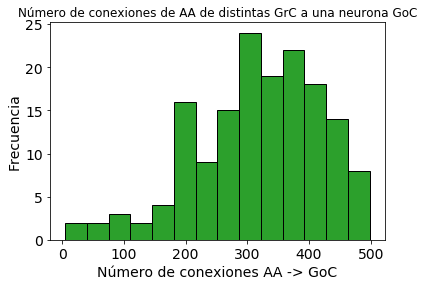

In [8]:
## Histograma frecuencia de convergencias de AA (GrC) en GoC

plt.hist(frAAtoGOCcon, bins = 14, color = 'tab:green', ec = 'k')
plt.ylabel('Frecuencia', fontsize = 14)
plt.xlabel('Número de conexiones AA -> GoC', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Número de conexiones de AA de distintas GrC a una neurona GoC')
plt.savefig('histrograma_AA_GoC.png', dpi=100, bbox_inches = "tight")

In [9]:
## distancias máximas, mínimas y medias de conexión

from __future__ import division
max_valueAA = max(distAA)
min_valueAA = min(distAA)
avg_valueAA = 0 if len(distAA) == 0 else sum(distAA)/len(distAA)

print(max_valueAA)
print(min_valueAA)
print(avg_valueAA)

[85.99989191]
[0.00026291]
[44.11619518]


## PF to GoC excitatory

In [10]:
filename = "PFtoGoC.h5"

with h5py.File(filename, "r") as hdf:
    base_items = list(hdf.items())
    print('Items in the base directory  ', base_items)
    connection = hdf.get('connection')
    connection_items = list(connection.items())
    print('Items in connection  ', connection_items)
    table = np.array(connection.get('_i_table'))
    dataset = np.array(connection.get('table'))
    print ('data dtype:', dataset.dtype, '\nshape:', dataset.shape)
    targetPF = dataset[:]['target'] 
    print ('target dtype:', targetPF.dtype, '\nshape:', targetPF.shape)
    sourcePF = dataset[:]['source'] 
    print ('source dtype:', sourcePF.dtype, '\nshape:', sourcePF.shape)
    distPF = dataset[:]['values_block_1'] 
    print ('dist dtype:', distPF.dtype, '\nshape:', distPF.shape)    

Items in the base directory   [('connection', <HDF5 group "/connection" (2 members)>)]
Items in connection   [('_i_table', <HDF5 group "/connection/_i_table" (3 members)>), ('table', <HDF5 dataset "table": shape (172448,), type "|V32">)]
data dtype: [('index', '<i8'), ('values_block_0', '<i4', (2,)), ('values_block_1', '<f8', (1,)), ('source', '<i4'), ('target', '<i4')] 
shape: (172448,)
target dtype: int32 
shape: (172448,)
source dtype: int32 
shape: (172448,)
dist dtype: float64 
shape: (172448, 1)


In [11]:
## Juntamos source (GrC) con target (GoC)
dfPF = pd.DataFrame({'sourcePF':sourcePF, 'targetPF':targetPF})
dfPF = dfPF.drop_duplicates()
## Frecuencia de cuántas AA de GrC distintas están unidas a cada Golgi
frPFtoGOCcon = dfPF.targetPF.value_counts()

In [12]:
# Número medio de veces que una GoC se conecta con un PF de una GrC distinta
# Es decir, RATIO DE CONVERGENCIA:
conPF = sum(frPFtoGOCcon)/len(frPFtoGOCcon)
print('Ratio de Convergencia PF to GoC ', sum(frPFtoGOCcon)/len(frPFtoGOCcon))

Ratio de Convergencia PF to GoC  746.2115384615385


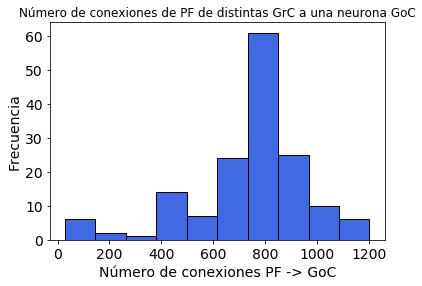

In [13]:
plt.hist(frPFtoGOCcon, bins = 10, color = 'royalblue', ec = 'k')
plt.ylabel('Frecuencia', fontsize = 14)
plt.xlabel('Número de conexiones PF -> GoC', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Número de conexiones de PF de distintas GrC a una neurona GoC')
plt.savefig('histrograma_PF_GoC.png', dpi=100, bbox_inches = "tight")

In [14]:
## Frecuencia de divergencia
frPFtoGOCdiv = dfPF.sourcePF.value_counts()
# Número medio de veces que una GrC se conecta por medio de su AA a una GoC distinta
# Es decir, RATIO DE DIVERGENCIA
divPF = sum(frPFtoGOCdiv)/len(frPFtoGOCdiv)
print('Ratio de Divergencia PF to GoC ', sum(frPFtoGOCdiv)/len(frPFtoGOCdiv))

Ratio de Divergencia PF to GoC  3.780249399233617


In [15]:
## distancias máximas, mínimas y medias de conexión

from __future__ import division

max_valuePF = max(distPF)
min_valuePF = min(distPF)
avg_valuePF = 0 if len(distPF) == 0 else sum(distPF)/len(distPF)

print(max_valuePF)
print(min_valuePF)
print(avg_valuePF)

[491.00266283]
[86.00001185]
[209.83101309]


## GoC to GoC inhibitory

In [16]:
dist = np.loadtxt( 'GoCtoGoCdistances.dat' )
source = np.loadtxt( 'GoCtoGoCsources.dat' )
target = np.loadtxt( 'GoCtoGoCtargets.dat' )

In [17]:
## Juntamos source (GrC) con target (GoC)
dfGOC = pd.DataFrame({'sourceGoC':source, 'targetGoC':target})
dfGOC = dfGOC.drop_duplicates()

In [18]:
# Número medio de veces que una GoC se conecta con una GoC distinta
# Es decir, RATIO DE CONVERGENCIA:
## Frecuencia de cuántas AA de GrC distintas están unidas a cada Golgi
frGOCtoGOCcon = dfGOC.targetGoC.value_counts()

conINH = sum(frGOCtoGOCcon)/len(frGOCtoGOCcon)
print('Ratio de Convergencia GoC to GoC ', sum(frGOCtoGOCcon)/len(frGOCtoGOCcon))

Ratio de Convergencia GoC to GoC  58.68987341772152


In [19]:
## Frecuencia de divergencia
frGOCtoGOCdiv = dfGOC.sourceGoC.value_counts()

# Número medio de veces que una GrC se conecta por medio de su AA a una GoC distinta
# Es decir, RATIO DE DIVERGENCIA
divINH = sum(frGOCtoGOCdiv)/len(frGOCtoGOCdiv)
print('Ratio de Divergencia GOC to GoC ', sum(frGOCtoGOCdiv)/len(frGOCtoGOCdiv))

Ratio de Divergencia GOC to GoC  58.68987341772152


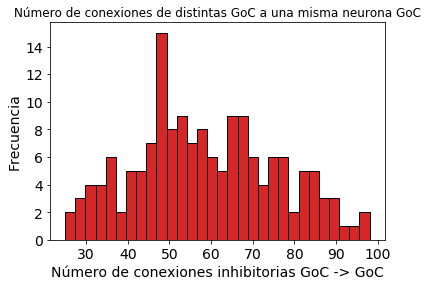

In [20]:
plt.hist(frGOCtoGOCcon, bins = 30, color = 'tab:red', ec = 'k')
plt.ylabel('Frecuencia', fontsize = 14)
plt.xlabel('Número de conexiones inhibitorias GoC -> GoC', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Número de conexiones de distintas GoC a una misma neurona GoC')
plt.savefig('histrograma_GoC_GoC_inh.png', dpi=100, bbox_inches = "tight")

In [21]:
from __future__ import division
max_valueINH = max(dist)
min_valueINH = min(dist)
avg_valueINH = 0 if len(dist) == 0 else sum(dist)/len(dist)

print(max_valueINH)
print(min_valueINH)
print(avg_valueINH)

281.60513529663706
42.884874956096084
162.9803342055337


## GoC to GoC gap

In [22]:
dist = np.loadtxt( 'GoCtoGoCgapdistances.dat' )
source = np.loadtxt( 'GoCtoGoCgapsources.dat' )
target = np.loadtxt( 'GoCtoGoCgaptargets.dat' )

In [23]:
## Juntamos source (GrC) con target (GoC)
dfGOCgap = pd.DataFrame({'sourceGoC':source, 'targetGoC':target})
dfGOCgap = dfGOCgap.drop_duplicates()
## Frecuencia de cuántas AA de GrC distintas están unidas a cada Golgi
frGOCtoGOCgapcon = dfGOCgap.targetGoC.value_counts()

In [24]:
## Frecuencia de divergencia
frGOCtoGOCgapdiv = dfGOCgap.sourceGoC.value_counts()
# Número medio de veces que una GrC se conecta por medio de su AA a una GoC distinta
# Es decir, RATIO DE DIVERGENCIA
divGAP = sum(frGOCtoGOCgapdiv)/len(frGOCtoGOCgapdiv)
print('Ratio de Divergencia GoC to GoC ', sum(frGOCtoGOCgapdiv)/len(frGOCtoGOCgapdiv))

Ratio de Divergencia GoC to GoC  8.822784810126583


In [25]:
# Número medio de veces que una GoC se conecta con una GoC distinta
# Es decir, RATIO DE CONVERGENCIA:
conGAP = sum(frGOCtoGOCgapcon)/len(frGOCtoGOCgapcon)
print('Ratio de Convergencia GoC to GoC ', sum(frGOCtoGOCgapcon)/len(frGOCtoGOCgapcon))

Ratio de Convergencia GoC to GoC  8.822784810126583


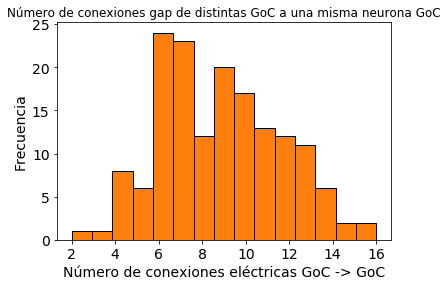

In [26]:
plt.hist(frGOCtoGOCgapcon, bins = 15, color = 'tab:orange', ec = 'k')
plt.ylabel('Frecuencia', fontsize = 14)
plt.xlabel('Número de conexiones eléctricas GoC -> GoC', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Número de conexiones gap de distintas GoC a una misma neurona GoC')
plt.savefig('histrograma_GoC_GoC_gap.png', dpi=100, bbox_inches = "tight")

In [27]:
from __future__ import division

max_valueGAP = max(dist)
min_valueGAP = min(dist)
avg_valueGAP = 0 if len(dist) == 0 else sum(dist)/len(dist)


print(max_valueGAP)
print(min_valueGAP)
print(avg_valueGAP)

79.98558682662771
42.03856086975384
62.30682308198212


## Glo to GrC

In [28]:
#dist = np.loadtxt( 'GLtoGCdistances.dat' )
source = np.loadtxt( 'GLtoGCsources.dat' )
target = np.loadtxt( 'GLtoGCtargets.dat' )

In [29]:
## Juntamos source (Glo) con target (GrC)
dfGlo = pd.DataFrame({'sourceGlo':source, 'targetGrC':target})
dfGlo = dfGlo.drop_duplicates()
## Frecuencia de cuántos Glo están conectadas a cada GrC
## Frecuencia de convergencia
frGlotoGrCcon = dfGlo.targetGrC.value_counts()

In [30]:
# Número medio de veces que una GoC se conecta con un AA de una GrC distinta
# Es decir, RATIO DE CONVERGENCIA:
conGlo = sum(frGlotoGrCcon)/len(frGlotoGrCcon)
print('Ratio de Convergencia Glo to GrC ', sum(frGlotoGrCcon)/len(frGlotoGrCcon))

Ratio de Convergencia Glo to GrC  4.149848350815114


In [31]:
## Frecuencia de divergencia
frGlotoGrCdiv = dfGlo.sourceGlo.value_counts()
# Número medio de veces que una GrC se conecta por medio de su AA a una GoC distinta
# Es decir, RATIO DE DIVERGENCIA
divGlo = sum(frGlotoGrCdiv)/len(frGlotoGrCdiv)
print('Ratio de Divergencia Glo to GrC ', sum(frGlotoGrCdiv)/len(frGlotoGrCdiv))

Ratio de Divergencia Glo to GrC  13.842449151649278


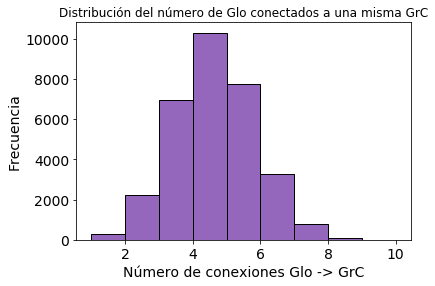

In [32]:
plt.hist(frGlotoGrCcon, bins = 9, color = 'tab:purple', ec = 'k')
plt.ylabel('Frecuencia', fontsize = 14)
plt.xlabel('Número de conexiones Glo -> GrC', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Distribución del número de Glo conectados a una misma GrC')
plt.savefig('histrograma_Glo_GrC_con.png', dpi=100, bbox_inches = "tight")

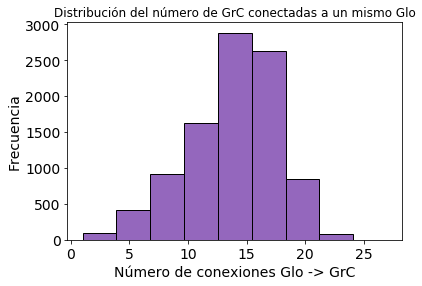

In [33]:
plt.hist(frGlotoGrCdiv, bins = 9, color = 'tab:purple', ec = 'k')
plt.ylabel('Frecuencia', fontsize = 14)
plt.xlabel('Número de conexiones Glo -> GrC', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Distribución del número de GrC conectadas a un mismo Glo')
plt.savefig('histrograma_Glo_GrC_div.png', dpi=100, bbox_inches = "tight")

## Distances analysis

In [34]:
### representación de las distancias medias para mis datos
### y los de la literatura 

dist_media = np.array([avg_valueAA, avg_valuePF, avg_valueINH, avg_valueGAP, 7.85])
dist_max = np.array([max_valueAA, max_valuePF, max_valueINH, max_valueGAP, 7.85])
dist_min = np.array([min_valueAA, min_valuePF, min_valueINH, min_valueGAP, 7.85])
ratio_con = np.array([conAA, conPF, conINH, conGAP, conGlo])
ratio_div = np.array([divAA, divPF, divINH, divGAP, divGlo])

In [35]:
mi_modelo = pd.DataFrame({'distmedia':dist_media, 'distmax':dist_max, 'distmin':dist_min, 'ratiocon':ratio_con, 'ratiodiv':ratio_div})

In [36]:
mi_modelo["distmedia"] = mi_modelo.distmedia.astype(float)
mi_modelo["distmax"] = mi_modelo.distmax.astype(float)
mi_modelo["distmin"] = mi_modelo.distmin.astype(float)

In [37]:
mi_modelo.index = ['AA - GoC', 'PF - GoC', 'GoC - GoC (inh)', 'GoC - GoC (gap)', 'Glo - Grc']

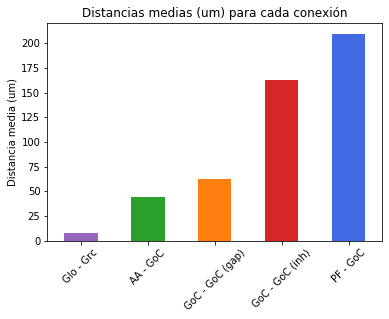

In [39]:
mi_modelo_dists = df1 = mi_modelo.iloc[:, 0:3] 
mi_modelo_dists = mi_modelo_dists.sort_values(by=['distmedia'])
df  = mi_modelo_dists.distmedia
ax = df.plot(kind='bar', rot=45, color=['tab:purple','tab:green', 'tab:orange','tab:red', 'royalblue'])
ax.set_title("Distancias medias (um) para cada conexión")
#ax.set_xlabel("Tipos de conexiones")
ax.set_ylabel("Distancia media (um)")
fig = ax.get_figure()
fig.savefig('distancias.png', dpi=100, bbox_inches = "tight")
#color={"AAtoGoC": "steelblue", "PFtoGoC": "royalblue", "GoCtoGoC(inh)": "tab:red", "GoCtoGoC(gap)": "tab:orange", "GlotoGrC": "tab:purple"}

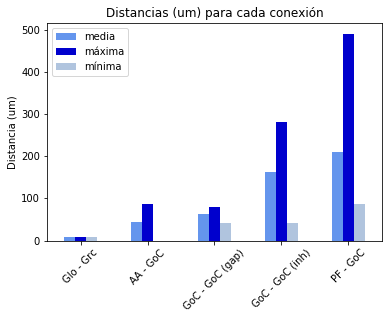

In [196]:
#fig, ax = plt.subplots()
mi_modelo_dists = mi_modelo_dists.sort_values(by=['distmedia'])
ax = mi_modelo_dists.plot(kind='bar', rot=45, color=['cornflowerblue', 'mediumblue', 'lightsteelblue'])
ax.set_title("Distancias (um) para cada conexión")
ax.set_ylabel("Distancia (um)")
labels = ['media', 'máxima', 'mínima']
ax.legend(labels)
fig = ax.get_figure()
fig.savefig('distancias_max_min_avg.png', dpi=100, bbox_inches = "tight")

#mi_modelo_dists.plot(kind='bar', ax=ax,  color=['tab:purple','tab:green', 'tab:orange','tab:red', 'royalblue'])
#ax.xticks(x, labels, rotation='vertical')

# Ratios Analysis

In [44]:
mi_modelo

,distmedia,distmax,distmin,ratiocon,ratiodiv
AA - GoC,44.116195,85.999892,0.000263,317.000000,1.900436
PF - GoC,209.831013,491.002663,86.000012,746.211538,3.780249
GoC - GoC (inh),162.980334,281.605135,42.884875,58.689873,58.689873
GoC - GoC (gap),62.306823,79.985587,42.038561,8.822785,8.822785
Glo - Grc,7.850000,7.850000,7.850000,4.149848,13.842449


In [55]:
ratioconlit = [400, 1000, 13.7, 2.2, 4]
ratioconlit = np.asarray(ratioconlit)

In [68]:
mi_modelo['ratioconlit'] = ratioconlit

In [70]:
df =  mi_modelo

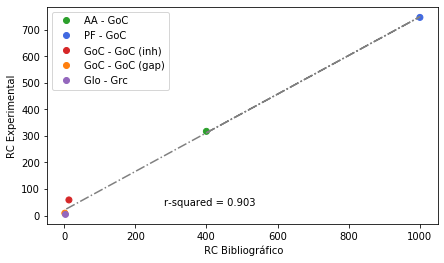

In [145]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import r2_score

x = df.ratioconlit
y = df.ratiocon

plt.figure(figsize=(7, 4))
ax = plt.axes()

m, b = np.polyfit(x, y, 1)
line = m*x + b

classes = ['AA - GoC', 'PF - GoC', 'GoC - GoC (inh)', 'GoC - GoC (gap)', 'Glo - Grc']

values = [0,1,2,3,4]

colours = ListedColormap(['tab:green','royalblue', 'tab:red', 'tab:orange', 'tab:purple'])

plt.annotate("r-squared = {:.3f}".format(r2_score(x, y)), xy=(1, 1), xytext=(100, 10), textcoords='offset points')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
ax.scatter(x, y, c=values, cmap=colours)
ax.plot(x, line, "-.", color = 'gray')

ax.set_xlabel(' RC Bibliográfico')
ax.set_ylabel('RC Experimental')

plt.show()

fig = ax.get_figure()
fig.savefig('convergence_ratios.png', dpi=100, bbox_inches = "tight")


In [187]:
b

-2.1782361081853843

 ### divergence ratios

In [150]:
ratiodivlit = [2, 4, 13.7, 2.2, 14]
ratiodivlit = np.asarray(ratiodivlit)
df['ratiodivlit'] = ratiodivlit
df

,distmedia,distmax,distmin,ratiocon,ratiodiv,ratioconlit,ratiodivlit
AA - GoC,44.116195,85.999892,0.000263,317.000000,1.900436,400.0,2.0
PF - GoC,209.831013,491.002663,86.000012,746.211538,3.780249,1000.0,4.0
GoC - GoC (inh),162.980334,281.605135,42.884875,58.689873,58.689873,13.7,13.7
GoC - GoC (gap),62.306823,79.985587,42.038561,8.822785,8.822785,2.2,2.2
Glo - Grc,7.850000,7.850000,7.850000,4.149848,13.842449,4.0,14.0


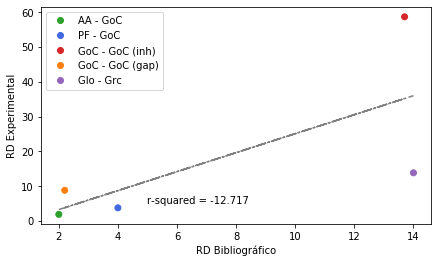

In [159]:
x = df.ratiodivlit
y = df.ratiodiv

plt.figure(figsize=(7, 4))
ax = plt.axes()

m, b = np.polyfit(x, y, 1)
line = m*x + b

classes = ['AA - GoC', 'PF - GoC', 'GoC - GoC (inh)', 'GoC - GoC (gap)', 'Glo - Grc']

values = [0,1,2,3,4]

colours = ListedColormap(['tab:green','royalblue', 'tab:red', 'tab:orange', 'tab:purple'])

plt.annotate("r-squared = {:.3f}".format(r2_score(x, y)), xy=(5, 5), xytext=(0, 0), textcoords='offset points')
fig = ax.get_figure()
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
ax.scatter(x, y, c=values, cmap=colours)
ax.plot(x, line, "-.", color = 'gray')

ax.set_xlabel('RD Bibliográfico')
ax.set_ylabel('RD Experimental')

plt.show()
fig = ax.get_figure()
fig.savefig('divergence_ratios.png', dpi=100, bbox_inches = "tight")
